# GNN STARTER PACK
From [here](https://www.kaggle.com/code/validmodel/graph-neural-network-starter-for-beginners).

## 1) The basic Math for graph structured data

#### Code

The function `create_adj(size)` takes a single argument, size, which is the number of nodes in the graph. This function will create a size x size adjacency matrix.

A size x size matrix of random values between 0 and 1 is created. Each value represents a potential connection between two nodes in the graph.

Any value greater than 0.5 is set to 1, indicating a connection between two nodes. Any value less than or equal to 0.5 is set to 0, indicating no connection. This creates a binary matrix where 1s represent edges and 0s represent no connection between pairs of nodes.

The function loops through each element in the matrix. If i == j, it sets a[i, j] = 0, which means there are no self-loops (a node is not connected to itself).

In [4]:
!pip install torchnet networkx

In [5]:
import torch


def create_adj(size):
    a = torch.rand(size,size)
    a[a>0.5] = 1    
    a[a<=0.5] = 0
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if i==j:
                a[i,j] = 0
    return a

## 2) Graph laplacian

#### Code
For the adjacency matrix `a`, `a.sum(dim=-1)` calculates the degree of each node by summing each row in `a`. This gives a vector where each entry represents the degree of a node. 

Then, `torch.diag(...)` creates a diagonal matrix from this degree vector, giving us the degree matrix 𝐷.

The function `graph_lapl(a)` computes the graph Laplacian matrix 𝐿 by subtracting the adjacency matrix 𝐴 from the degree matrix 𝐷.

In [8]:
def degree_matrix(a):
  return torch.diag(a.sum(dim=-1))

a = create_adj(5)
d = degree_matrix(a)

from colorama import Fore

print(" Degree matrix D:\n", d)

def graph_lapl(a):
  return degree_matrix(a)-a

print(" Adjacency matrix A:\n", a)
print(" Laplacian matrix L:\n", graph_lapl(a))

 Degree matrix D:
 tensor([[2., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0.],
        [0., 0., 2., 0., 0.],
        [0., 0., 0., 3., 0.],
        [0., 0., 0., 0., 2.]])
 Adjacency matrix A:
 tensor([[0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0.],
        [0., 1., 0., 1., 0.]])
 Laplacian matrix L:
 tensor([[ 2., -1., -1.,  0.,  0.],
        [-1.,  3., -1.,  0., -1.],
        [-1.,  0.,  2.,  0., -1.],
        [-1., -1., -1.,  3.,  0.],
        [ 0., -1.,  0., -1.,  2.]])


#### Code
The function `nx.petersen_graph()` generates a predefined graph structure known as the Petersen graph, which has 10 nodes and 15 edges.

Different layout styles of the same graph are presented.

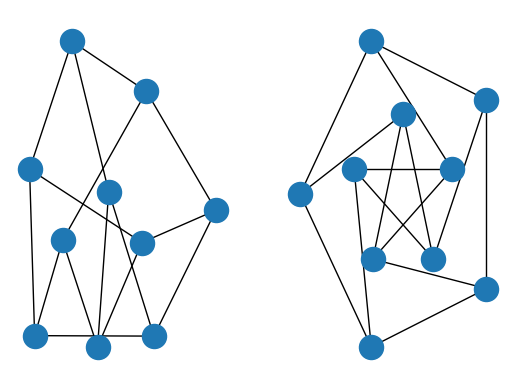

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=False, font_weight='bold')

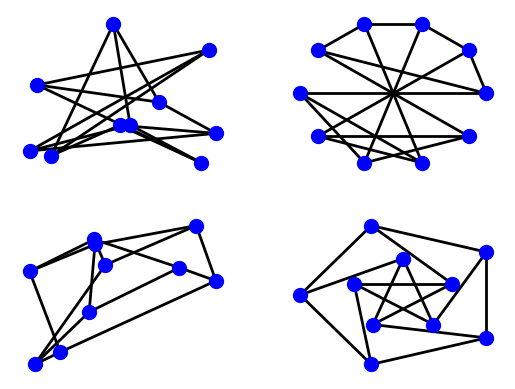

In [11]:
options = {
   'node_color': 'blue',
   'node_size': 100,
   'width': 2,
}
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)

## 3) Normalization
Degree-based normalization ensures that each node’s contribution is proportional to its degree, preventing high-degree nodes from overwhelming low-degree nodes during message passing.

#### Code
This normalized degree matrix has values 1/sqrt(𝑑_𝑖) along the diagonal where  𝑑_𝑖 is the degree of node 𝑖.

The function `graph_lapl_norm(a)` computes the normalized graph Laplacian 𝐿norm = 𝐼 − 𝐷norm𝐴𝐷norm

Here, `@` represents matrix multiplication.

The matrix multiplication 𝐷norm𝐴𝐷norm scales each node’s connections by its degree, effectively normalizing the adjacency matrix.

In [14]:
def degree_matrix_norm(a):
  return torch.diag(torch.pow(a.sum(dim=-1),-0.5))

def graph_lapl_norm(a):
  size = a.shape[-1]
  D_norm = degree_matrix_norm(a)
  L_norm = torch.ones(size) - (D_norm @ a @ D_norm )
  return L_norm

## 4) General Graph Convolution
We implement Chebyshev polynomial approximation for graph convolution using the Chebyshev Laplacian. This approach is a technique for defining convolution on graphs, particularly to approximate the spectral graph convolution efficiently.
In graph convolution, we want to use higher-order relationships (or multi-hop neighbors), which Chebyshev polynomials can approximate without directly computing costly matrix powers.

#### Code
The function `find_eigmax` finds the largest eigenvalue of the graph Laplacian matrix 𝐿. The largest eigenvalue helps to rescale 𝐿 so that it is within a range that facilitates the Chebyshev approximation.

The function `chebyshev_Lapl` computes the Chebyshev approximation of the graph convolution layer. Its inputs are; `X`, the node feature matrix.
`Lapl`, the graph Laplacian matrix, `thetas`, trainable parameters (weights) for each order of the Chebyshev polynomial, and `order` the maximum power (order) of Chebyshev polynomials to compute.

Here, we first rescale the laplacian to control the range of eigenvalues, then we set up initial values for Chebyshev polynomial calculations, recursively compute higher-order terms, concatenate powers, and reshape the output.

After computing the Chebyshev approximation, the resulting output (with shape [nodes, order * features]) is passed through a linear layer with dimensions 4*3 (due to 4 Chebyshev orders and 3 features). This linear transformation serves as a learnable layer that combines the information from different orders to produce an output of the desired size (out_features).

The variable `power_order` (set to 4 in the example) defines the number of hops or "Chebyshev polynomial terms" to consider.

In [17]:
import torch
import torch.nn as nn

def find_eigmax(L):
    with torch.no_grad():
        # Use the updated `torch.linalg.eigvals` to get eigenvalues directly
        e1 = torch.linalg.eigvals(L)
        # Extract the maximum absolute value for real parts
        return torch.max(e1.real).item()

def chebyshev_Lapl(X, Lapl, thetas, order):
    list_powers = []
    nodes = Lapl.shape[0]

    T0 = X.float()

    eigmax = find_eigmax(Lapl)
    L_rescaled = (2 * Lapl / eigmax) - torch.eye(nodes)

    y = T0 * thetas[0]
    list_powers.append(y)
    T1 = torch.matmul(L_rescaled, T0)
    list_powers.append(T1 * thetas[1])

    # Computation of: T_k = 2*L_rescaled*T_k-1 - T_k-2
    for k in range(2, order):
        T2 = 2 * torch.matmul(L_rescaled, T1) - T0
        list_powers.append((T2 * thetas[k]))
        T0, T1 = T1, T2
    
    y_out = torch.stack(list_powers, dim=-1)
    y_out = y_out.view(nodes, -1)  # Concatenate the powers along nodes
    return y_out

# Testing the modified function
features = 3
out_features = 50
a = torch.randint(0, 2, (10, 10), dtype=torch.float32)
L = graph_lapl_norm(a)
x = torch.rand(10, features)
power_order = 4  # p-hops
thetas = nn.Parameter(torch.rand(4))

out = chebyshev_Lapl(x, L, thetas, power_order)

print('cheb approx out powers concatenated:', out.shape)
linear = nn.Linear(4 * 3, out_features)

layer_out = linear(out)
print('Layers output:', layer_out.shape)

cheb approx out powers concatenated: torch.Size([10, 12])
Layers output: torch.Size([10, 50])


## 5) Implementing 1-hop GCN layer in a small graph dataset¶
Our GCN layer will be defined by the following equations along with its pytorch implementatino:

Y=LnorX .W⋅

Where Lnorm is the normalized graph Laplacian matrix <br> 
𝑋 is the input feature matrix for each node in the graph. Each node in the graph has its own set of features <br>.
𝑊 is the trainable weight matrix for the graph convolution layer <br>.Y  is the output of the graph convolution operation (after applying the normalized graph Laplacian to the input features and multiplying by the weights)


Lmod,norm = (1/sqrt(D))(A+I)(1/sqrt(D) )

Where Lmod,norm is the normalized graph Laplacian, which is used to account for the graph structure and normalize the data based on node degrees.n

### Dataset
Dataset used is the [MUTAG](https://www.kaggle.com/datasets/tammodukker/mutag-dataset) dataset.

In particular, MUTAG is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. **It includes 188 samples of chemical compounds with 7 discrete node labels**.

#### Code
The function `device_as` takes two tensors x and y and moves tensor x to the same device as y. This is important when we are working with multi-device environments (like when we are using a GPU), ensuring that all tensors are on the same device to avoid device mismatch errors during computation.

The function `calc_degree_matrix_norm(a)` calculates the normalized degree matrix for the adjacency matrix a.

The function `create_graph_lapl_norm(a)` constructs the normalized graph Laplacian, which will be used in the GCN layer.

The graph convolution operation happens in the `forward` method. <br>
It applies a linear transformation to the input feature matrix X. This is done using a fully connected layer (nn.Linear) which will learn the weights. <br> 
Then, it performs a batch matrix multiplication (bmm) to apply the graph convolution. This step propagates the features through the graph using the normalized Laplacian L. The result is a graph representation that integrates information from neighboring nodes. 

In [21]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

def device_as(x,y):
  return x.to(y.device)

# tensor operationa now support batched inputs
def calc_degree_matrix_norm(a):
  return torch.diag_embed(torch.pow(a.sum(dim=-1),-0.5))

def create_graph_lapl_norm(a):
  size = a.shape[-1]
  a +=  device_as(torch.eye(size),a)
  D_norm = calc_degree_matrix_norm(a)
  L_norm = torch.bmm( torch.bmm(D_norm, a) , D_norm )
  return L_norm

class GCN(nn.Module):
    """
    A simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, bias=True):
      super().__init__()
      self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, X, A):
        """
        A: adjecency matrix
        X: graph signal
        """
        L = create_graph_lapl_norm(A)
        x = self.linear(X)
        return torch.bmm(L, x)

#### Code
The function `indices_to_one_hot` converts an index (e.g., a class label) into a one-hot encoded vector. If the index is the "dummy" value (-1 by default), it returns a vector of zeros. Otherwise, it creates a one-hot encoded vector of length nb_classes where only the position corresponding to the index is 1.

The function `get_graph_signal` extracts the node features (attributes) from a NetworkX graph (nx_graph). It creates a dictionary of the graph's nodes and their associated attributes (attr_dict). The resulting list x contains the attributes of each node, which will later be used as the "graph signal" for each node.

The function `load_data` loads the graph dataset from text files, processes the graph structure, and optionally loads node labels. The function reads the graph_indicator file, which maps nodes to graphs. It creates a list Gs of graphs, adding nodes to the correct graph. Then, it reads the adjacency matrix (A.txt) and adds edges between nodes in the corresponding graphs. If use_node_labels is True, it reads the node labels and one-hot encodes them. These labels are added as node attributes to the graph. After that, it reads the graph-level labels and stores them in the labels list. Finally, the function returns a list of tuples, where each tuple contains a graph (Gs) and its corresponding label (labels).

The function `create_loaders` splits the dataset into a training set and a validation set at the index split_id.

The function `to_pytorch_dataset` converts the list of graphs and labels into PyTorch tensors. It wraps the dataset into a PyTorch DataLoader, which handles batching and shuffling.

In [23]:
import torchnet as tnt
import os
import networkx as nx
import numpy as np
import torch

def indices_to_one_hot(number, nb_classes, label_dummy=-1):
    """Convert an iterable of indices to one-hot encoded labels."""
    if number == label_dummy:
        return np.zeros(nb_classes)
    else:
        return np.eye(nb_classes)[number]

def get_graph_signal(nx_graph):
  d = dict((k, v) for k, v in nx_graph.nodes.items())
  x = []
  invd = {}
  j = 0
  for k, v in d.items():
      x.append(v['attr_dict'])
      invd[k] = j
      j = j + 1
  return np.array(x)


def load_data(path, ds_name, use_node_labels=True, max_node_label=10):
    node2graph = {}
    Gs = []
    data = []
    dataset_graph_indicator = f"{ds_name}_graph_indicator.txt"
    dataset_adj = f"{ds_name}_A.txt"
    dataset_node_labels = f"{ds_name}_node_labels.txt"
    dataset_graph_labels = f"{ds_name}_graph_labels.txt"

    path_graph_indicator = os.path.join(path,dataset_graph_indicator)
    path_adj = os.path.join(path,dataset_adj)
    path_node_lab = os.path.join(path,dataset_node_labels)
    path_labels = os.path.join(path,dataset_graph_labels)


    with open(path_graph_indicator, "r") as f:
        c = 1
        for line in f:
            node2graph[c] = int(line[:-1])
            if not node2graph[c] == len(Gs):
                Gs.append(nx.Graph())
            Gs[-1].add_node(c)
            c += 1

    with open(path_adj, "r") as f:
        for line in f:
            edge = line[:-1].split(",")
            edge[1] = edge[1].replace(" ", "")
            Gs[node2graph[int(edge[0])] - 1].add_edge(int(edge[0]), int(edge[1]))

    if use_node_labels:
      with open(path_node_lab, "r") as f:
        c = 1
        for line in f:
          node_label = indices_to_one_hot(int(line[:-1]), max_node_label)
          Gs[node2graph[c] - 1].add_node(c, attr_dict=node_label)
          c += 1

    labels = []
    with open(path_labels, "r") as f:
        for line in f:
            labels.append(int(line[:-1]))

    return list(zip(Gs, labels)) 

def create_loaders(dataset, batch_size, split_id, offset=-1):
    train_dataset = dataset[:split_id]
    val_dataset = dataset[split_id:]
    return to_pytorch_dataset(train_dataset, offset,batch_size), to_pytorch_dataset(val_dataset, offset,batch_size)

def to_pytorch_dataset(dataset, label_offset=0, batch_size=1):
  list_set = []
  for graph, label in dataset:
    F, G = get_graph_signal(graph), nx.to_numpy_array(graph)  # Changed here
    numOfNodes = G.shape[0]
    F_tensor = torch.from_numpy(F).float()
    G_tensor = torch.from_numpy(G).float()

    # fix labels to zero-indexing
    if label == -1:
      label = 0
    
    label += label_offset
    
    list_set.append(tuple((F_tensor, G_tensor, label)))

  dataset_tnt = tnt.dataset.ListDataset(list_set)
  data_loader = torch.utils.data.DataLoader(dataset_tnt, shuffle=True, batch_size=batch_size)
  return data_loader



dataset = load_data(path='C:/Users/Arslan/Desktop/All Data/MUTAG/', ds_name='C:/Users/Arslan/Desktop/All Data/MUTAG/MUTAG',
                  use_node_labels=True, max_node_label=7)
train_dataset, val_dataset = create_loaders(dataset, batch_size=1, split_id=150, offset=0)
print('Data are ready')

Data are ready


#### Code
This section defines a GNN model in PyTorch for node classification or graph-level classification.

First, GNN is defined as a subclass of torch.nn.Module, the base class for all neural network models in PyTorch.

Each GCN layer (self.conv1-2-3) learns a new feature representation by aggregating information from neighboring nodes. <br>
conv1 maps the input features (in_features) to the hidden dimension (hidden_dim), while conv2 and conv3 maintain the hidden_dim size. <br>
Here, `self.fc` is a fully connected (linear) layer that outputs class probabilities for graph classification and `self.dropout` is the dropout probability for regularizing the model.

The `forward` forward pass method has inputs `x` as node features matrix with dimensions [batch_size, num_nodes, in_features] and `A` as adjacency matrix representing the graph's structure. <br>
The 3 GCN layers apply: <br>
    -Layer 1: self.conv1(x, A) applies the first GCN layer to the input features, followed by a ReLU activation function, F.relu(x), for non-linearity.<br>
    -Layer 2: self.conv2(x, A) applies the second GCN layer and ReLU again.<br>
    -Layer 3: self.conv3(x, A) applies the third GCN layer. <br>
    
After the GCN layers, dropout is applied with `F.dropout`, which randomly zeroes out elements of x during training to prevent overfitting.

`x.mean(dim=1)` averages node embeddings across nodes to obtain a single graph embedding (graph-level representation).

The final fully connected layer self.fc(x) outputs a prediction for each class, which is used for classification.


In [25]:
import torch
import torch.nn as nn

class GNN(nn.Module):
  def __init__(self,
                    in_features = 7,
                    hidden_dim = 64,
                    classes = 2,
                    dropout = 0.5):
    super(GNN, self).__init__()

    self.conv1 = GCN(in_features, hidden_dim)
    self.conv2 = GCN(hidden_dim, hidden_dim)
    self.conv3 = GCN(hidden_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, classes)
    self.dropout = dropout

  def forward(self, x,A):
    x = self.conv1(x, A)
    x = F.relu(x)
    x = self.conv2(x, A)
    x = F.relu(x)
    x = self.conv3(x, A)
    x = F.dropout(x, p=self.dropout, training=self.training)
    # aggregate node embeddings
    x = x.mean(dim=1)
    # final classification layer
    return self.fc(x)

#### Code

We first define the loss function as cross-entropy loss and then set the device to GPU (if available) or CPU.

We create an instance of the GNN class with specified input features, hidden dimensions, and output classes. This model is then moved to the selected device (CPU or GPU). Then, we initialize the Stochastic Gradient Descent (SGD) optimizer, which adjusts model parameters during training to minimize the loss.

We then set the model in training mode, enabling features like dropout (used in regularization). And loop over batches in train_loader, which loads the training data in mini-batches. <br>
Here, we extract node features X, adjacency matrix A, and labels from each batch, move them to the selected device, and run a forward pass, which applies the GNN layers and returns predictions. <br>
After that, we calculate the loss by comparing predictions (`out`) to the true labels, backpropagate to compute gradients for each model parameter, and update the parameters using gradients computed during backpropagation.

After these, we put the model in evaluation mode, which disables certain layers like dropout. We initialize a counter for correctly classified samples and iterate over the data batches in the specified loader. <br>
We find the predicted class for each sample by selecting the index of the highest output value. Then, we compare predictions (`pred`) with the actual labels and counts correct predictions. We finally compute and return the accuracy as the fraction of correct predictions.

In the end, we apply a training loop. <br>
We first initialize a variable to store the highest validation accuracy found during training and enter the main training loop running for 240 epochs. <br> We call the train function to update model parameters based on the training data and calculate the model’s accuracy on the training set.
Then, we calculate the model’s accuracy on the validation set, check if the current validation accuracy exceeds the best accuracy so far and update them accordingly.
Every 10 epochs, we print the current epoch, training accuracy, validation accuracy, and the best validation accuracy seen so far.

In [27]:
# Only check for cuda if it's available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train and test functions with .to(device)
def train(train_loader):
    model.train()

    for data in train_loader: 
      optimizer.zero_grad()  
      X, A, labels = data
      X, A, labels = X.to(device), A.to(device), labels.to(device)  
      # Forward pass.
      out = model(X, A)  
      # Compute the graph classification loss.
      loss = criterion(out, labels) 
      # Calculate gradients.
      loss.backward()  
      # Updates the models parameters
      optimizer.step() 

def test(loader):
  model.eval()
  correct = 0
  for data in loader:
    X, A, labels = data
    X, A, labels = X.to(device), A.to(device), labels.to(device)  
    # Forward pass.
    out = model(X, A)  
    # Take the index of the class with the highest probability.
    pred = out.argmax(dim=1) 
    # Compare with ground-truth labels.
    correct += int((pred == labels).sum()) 
  return correct / len(loader.dataset)  

best_val = -1
for epoch in range(1, 241):
    train(train_dataset)
    train_acc = test(train_dataset)
    val_acc = test(val_dataset)
    if val_acc>best_val:
      best_val = val_acc
      epoch_best = epoch
    
    if epoch%10==0:
      print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} || Best Val Score: {best_val:.4f} (Epoch {epoch_best:03d}) ')

NameError: name 'model' is not defined

## Saving the trained model for deployment
In PyTorch, saving the model involves saving its state dictionary (which holds the parameters of the model) to a file.

In [ ]:
# After training completes
model_path = 'gnn_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# Initialize the model structure with the same parameters as before
model = GNN(in_features=7, hidden_dim=128, classes=2)
model.load_state_dict(torch.load(model_path))  # Load the trained parameters
model = model.to(device)  # Move the model to the appropriate device

# Set the model to evaluation mode for inference
model.eval()
print("Model loaded and ready for inference")

# Assume `new_graph` is a NetworkX graph you want to classify
# Prepare node features and adjacency matrix in the same format as your training data
X = torch.from_numpy(get_graph_signal(new_graph)).float().to(device)  # Node features as a tensor
A = torch.from_numpy(nx.to_numpy_array(new_graph)).float().to(device)  # Adjacency matrix as a tensor

# Add batch dimension if your model expects it
X = X.unsqueeze(0)  # Shape: (1, num_nodes, num_features)
A = A.unsqueeze(0)  # Shape: (1, num_nodes, num_nodes)

# Forward pass through the model
with torch.no_grad():  # Disable gradient computation for inference
    output = model(X, A)
    predicted_class = output.argmax(dim=1).item()  # Get predicted class index

print(f"Predicted class for the new graph: {predicted_class}")